## Rooftop Solar Panel Detection using CNN - SPARTIFICIAL
### Understanding the problem statement
#### Why detect the solar panels?
- The world is increasingly turning to solar energy as a clean and renewable source of power. 
- By 2050, solar energy is predicted to be one of the world's leading energy sources, with solar PV (photovoltaic) systems mounted on rooftops playing a significant role. In the US alone, solar energy production has increased by 39 times between 2008 and 2017.

#### Why is it important to detect solar panels?
Accurately tracking solar panel installations helps:
- Solar power suppliers and consumers: Manage energy production and consumption.
- Urban planners: Design cities for optimal solar energy utilization.
- Grid system operators: Balance the power grid with increasing solar energy integration.
- Energy policy makers: Formulate effective policies for renewable energy development.

**Current Challenges:**
- Limited data: Granular data on rooftop solar PV installations is scarce.
- Lack of algorithms: Few existing algorithms for identifying solar panels in aerial or satellite imagery.

**Solution:**
- This project aims to develop a deep learning algorithm that can automatically detect and map rooftop solar panels from aerial or satellite images.

In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

### 1. Import Necessary dependencies

In [20]:
'''Data Handling & Linear Algebra'''
import numpy as np
import pandas as pd

'''Visualisation'''
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams

'''Data Analysis'''
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report

'''Manipulating Data and Model Building'''
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import Add, BatchNormalization, Dense

### 2. Import the dataset

In [21]:
# Accessing Image Files: Usig the os library to access all image files in a specific directory.
path = '/kaggle/input/solarpaneldetection-cnn-spartificial/data/training/'
train_images = os.listdir(path)
# train_images

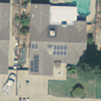

In [22]:
#Loaidng the images using PIL
from PIL import Image

# Example: Loading the first image
image_path = os.path.join(path, train_images[9])
img = Image.open(image_path)
img

### 3. Exploratory Data Analysis (EDA)

In [23]:
train_images = '/kaggle/input/solarpaneldetection-cnn-spartificial/data/training/'
train_labels = '/kaggle/input/solarpaneldetection-cnn-spartificial/data/labels_training.csv'

In [24]:
df = pd.read_csv("/kaggle/input/solarpaneldetection-cnn-spartificial/data/labels_training.csv")
df.head()

,id,label
0,0,0
1,1,0
2,2,1
3,3,1
4,4,1


- id are the names of the image before .tif
- label has two values
       
       - 0: No solar panels in the image
       - 1: Solar panels in the image

Our goal is to 
- build a function to prepare the dataset, 
- store all the image data in an array and 
- store all the respective labels data in the array

#### 3.1 LOADING DATA AND PREPROCESSING


In [25]:
def load_data(dir_path,dir_labels):
    '''
    dir_data: Data directory
    dir_label: Respective csv file containing ids and labels
    returns: Array of all the image arrays and its respective labels
    '''
    labels_pd = pd.read_csv(dir_labels)                   #Read the csv file with ids and labels 
    ids = labels_pd.id.values                             #Extract the ids from the csv file
    data = []
    
    for index in ids:                                     #Looping into the desired folder
        fname = dir_path + index.astype(str) + '.tif'     #Generating the file name
        image = mpl.image.imread(fname)                   #Reading image as numpy array using matplotlib
        data.append(image)                                #Appending the image array to the empty list and iterating the cycle
        
    data = np.array(data)                                 #Converting the data list to an array
    labels = labels_pd.label.values                       #Extract labels from the csv file
    
    return data, labels                                   #Return the array of data and respective labels
        

id(image) - label

**Function of the load_data method**
1. read the csv file
2. extract ids from csv file
3. create an empty list 'data' to contain all the info
4. run a loop through ids
    - generate the file name
    - corresponding image
    - append image into the empty list data
5. extract labels from the csv file
6. return data and labels

In [26]:
#Load the train data
X,y = load_data(train_images, train_labels)
# X,y

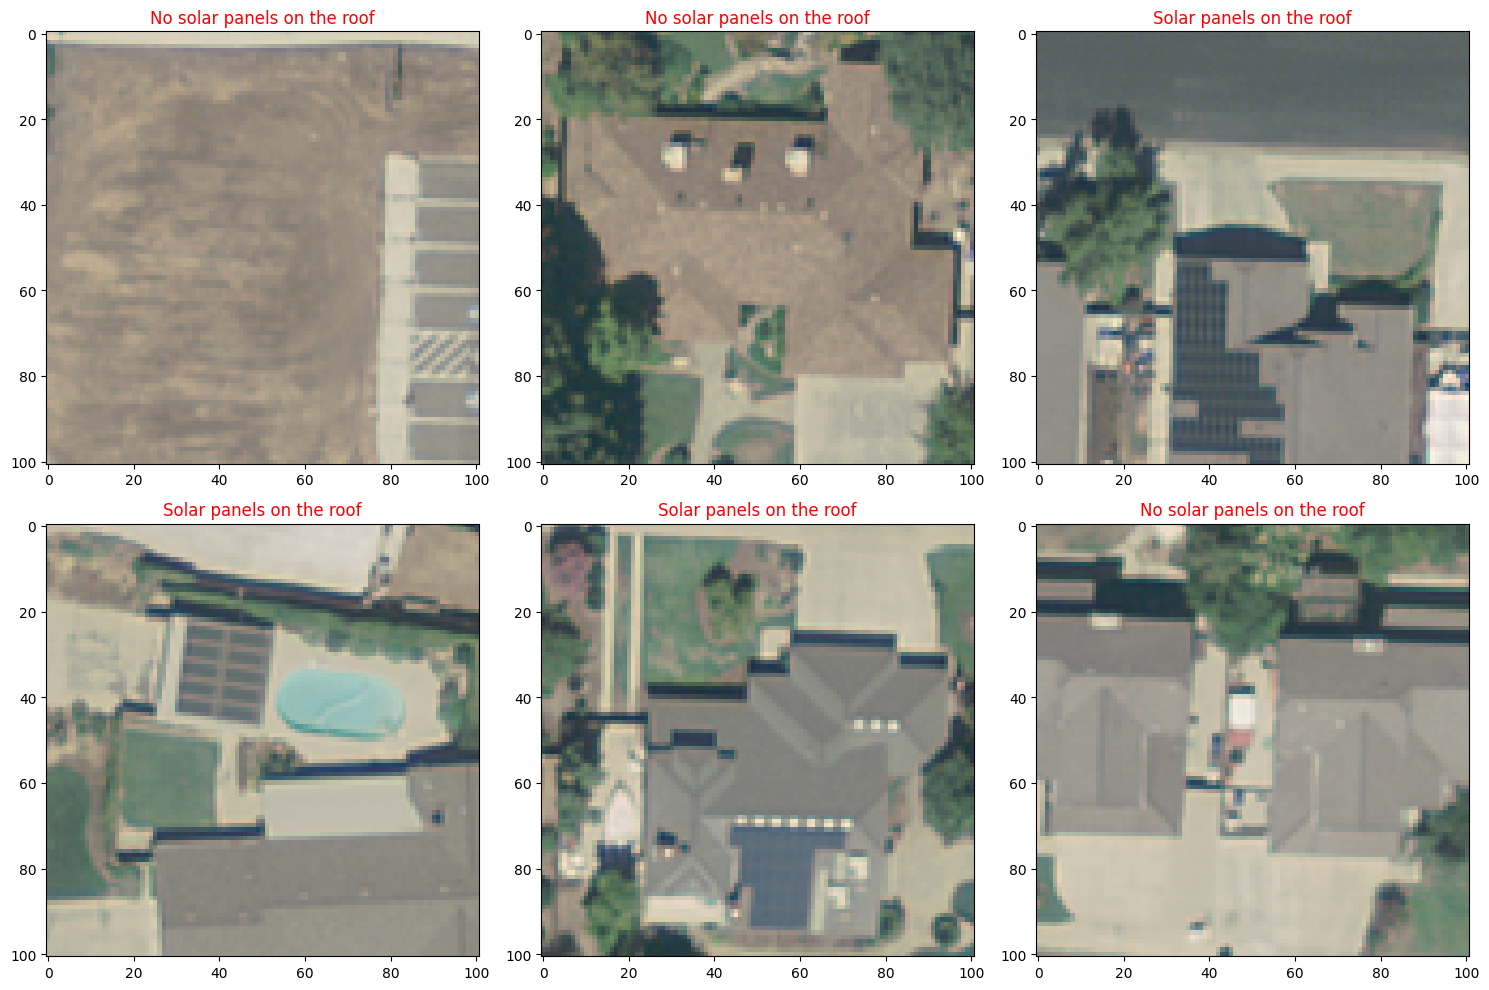

In [27]:
#Visualize the images and labels
plt.figure(figsize=(15,10))

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i])       # Show the respective image in respective postion
    if y[i]==0:
        title = "No solar panels on the roof"
    else:
        title = "Solar panels on the roof"
    plt.title(title,c='r')
    
plt.tight_layout()         # Automatically adjusts the width and height between images in subplot
plt.show()

In [28]:
print(f"X Shape: {X.shape}")

X Shape: (1500, 101, 101, 3)


- X contains 1500 images in training data
- Each image has shape  (101 x 101 x 3) , 3 - RGB Channels

In [29]:
#Calculate the distribution of target labels y
print(f"Distribution of y: {np.bincount(y)}")

Distribution of y: [995 505]


Out of 1500 images in the dataset
- 995 have no solar panels on the rooftop
- 505 have solar panels on the rooftop

In [30]:
#Scaling the images pixel value in between 0 and 1
X = X/255
# X[:3]

## 4. Building the CNN Model
**CNN - Convolutional Neural Network**
- It is a deep learning model used for image related tasks like image detection, image classification. It consists of convolutional layers to extract features like edges and shapes. They downsample through pooling layers, aiding computing efficiency. They are very efficient and significant in performing image tasks, as they hierarchically capture patterns. 

- The convolutional layer applies a convolution operation, the output is passed to the next layer. The pool layer performs a down sampling operation by combining the outputs of neurons at one layer into a single neuron in the next layer. The flatten reshapes the feature map into a column. The full-connection layer will compute the class scores, each neuron in this layer will be connected to all the neurons in the previous one
1. Conv2D() - Performs convolutional operation --> applying filters to input data to extract features
2. BatchNormalisation() -Normalises and scales the activation of each layer. Acts as regularizer, to prevent overfitting
3. MaxPooling2D() - Pooling layer for downsampling (output the max value of a filter)
4. GlobalMaxPooling2D() -  Used as asubstitute to flatten layer
5. Dense - Fully connected Layer

#### 4.1 Model Building

In [31]:
def build_model():
    '''Returns a keras CNN model'''
    
    #define image dimensions
    image_height = 101
    image_width = 101
    image_channels = 3
    
    model = Sequential()
    
    #Layer 1 
    #filter - 32, kernel_size = 3X3 matrix(filter), and When using CNN as first layer, use this argument input_shape = (101,101,3)
    model.add(Conv2D(filters=32,kernel_size=3, activation='relu',
                     input_shape=(image_height,image_width,image_channels)))
    model.add(BatchNormalization()) #Normalizing layer to improve training speed
    
    #Layer 2
    #Add complexity to further layers
    model.add(Conv2D(filters=64, kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    
    #Layer 3
    model.add(Conv2D(filters=128, kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = 2))    #Pooling Layer to downsample the dimensions of the features
    # max-pool - sends only max value of the filter (imp data) to next layer - here 2x2 matrix

    #Layer 4
    model.add(Conv2D(filters=64, kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    
    #Layer 5
    model.add(Conv2D(filters=128, kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    
    #Layer 6
    model.add(Conv2D(filters=64, kernel_size=3,activation='relu'))
    model.add(BatchNormalization())   
    
    #Layer 7
    model.add(Conv2D(filters=128, kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    
    #Global-max-pool - downsamples further- basically flatten the output before passing it to the final layer
    model.add(GlobalMaxPooling2D())
    
#     Penultimate layer
    model.add(Dense(16, activation='relu'))

    #Output Layer
    model.add(Dense(1, activation='sigmoid'))
    
    #Compile the model
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    
    return model

#### 4.2 Performance Metrics

In [32]:
#Cross Validation CNN model
def cv_performance_metrics(X,y,num_folds,clf,random_seed=2):
    '''
    Inputs: 
        X,y: training data, training labels
        num_folds: number of folds for cross validation
        clf: classifier to use 
        
          Divide the training data into k folds of training and validation data.
    For each fold the classifier will be trained on the training data and
    tested on the validation data. The classifier prediction scores are
    aggregated and output.
    '''
    pred_scores = np.empty(y.shape[0], dtype='object')
    
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_seed)
    
    for train_index, val_index in skf.split(X,y):
        #extract the training and validation data for this fold
        X_train, X_val = X[train_index],X[val_index]
        y_train,y_test = y[train_index], y[val_index]
        
        #Give more weight to the minority class based on the target class distribution
        class_weight = {0:505/1500,1:995/1500}
        
        #Train the classifier
        training = clf.fit(x=X_train,y=y_train, class_weight=class_weight,batch_size=32,
                           epochs=10,shuffle=True)
        
        #Predict the validation data
        y_pred_val = clf.predict(X_val).reshape((-1,))
        
        pred_scores[val_index] = y_pred_val
        
    return pred_scores

In [33]:
num_folds = 5
random_seed = 26

cnn = build_model()
# cnn.summary()

In [34]:
y_pred_cnn = cv_performance_metrics(X,y,num_folds,cnn, random_seed=random_seed)

Epoch 1/10
38/38 [==============================] - 9s 106ms/step - loss: 0.2464 - accuracy: 0.7125
Epoch 2/10
38/38 [==============================] - 3s 73ms/step - loss: 0.1531 - accuracy: 0.8692
Epoch 3/10
38/38 [==============================] - 3s 73ms/step - loss: 0.1168 - accuracy: 0.9008
Epoch 4/10
38/38 [==============================] - 3s 74ms/step - loss: 0.0907 - accuracy: 0.9233
Epoch 5/10
38/38 [==============================] - 3s 74ms/step - loss: 0.0764 - accuracy: 0.9408
Epoch 6/10
38/38 [==============================] - 3s 74ms/step - loss: 0.0663 - accuracy: 0.9458
Epoch 7/10
38/38 [==============================] - 3s 74ms/step - loss: 0.0501 - accuracy: 0.9600
Epoch 8/10
38/38 [==============================] - 3s 74ms/step - loss: 0.0352 - accuracy: 0.9717
Epoch 9/10
38/38 [==============================] - 3s 74ms/step - loss: 0.0317 - accuracy: 0.9758
Epoch 10/10
10/10 [==============================] - 1s 65ms/step
Epoch 1/10
38/38 [========================

###### Accuracy is not a good measure here when we are dealing with imbalanced datasets. Thus, let us check the confusion matrix to delve deeper and understand the results

In [35]:
# y_pred

##### True Positives, False Negatives, False positives and True Negatives

In [36]:
df = pd.read_csv(train_labels)
df['predicted_score'] = [1 if pred >= 0.5 else 0 for pred in y_pred_cnn]

#Get the values for FN,FP,TP,TN
fn = np.array(df[(df.label == 1) & (df['predicted_score']==0)]['id'])
fp = np.array(df[(df.label == 0) & (df['predicted_score']==1)]['id'])
tn = np.array(df[(df.label == 0) & (df['predicted_score']==0)]['id'])
tp = np.array(df[(df.label == 1) & (df['predicted_score']==1)]['id'])

In [37]:
#Visualizing TN,TP,FN,FP
def show_images(image_ids, num_images,title, color):
    
    rcParams['figure.figsize'] = 20,4
    plt.figure()
    n=1
    for i in image_ids[0:num_images]:
        plt.subplot(1, num_images, n)
        plt.imshow(X[i,:,:,:])
        plt.title("Image id"+str(i))
        plt.axis('off')
        n+=1
    plt.suptitle("\n"+title,color=color,weight='bold')
    plt.show()

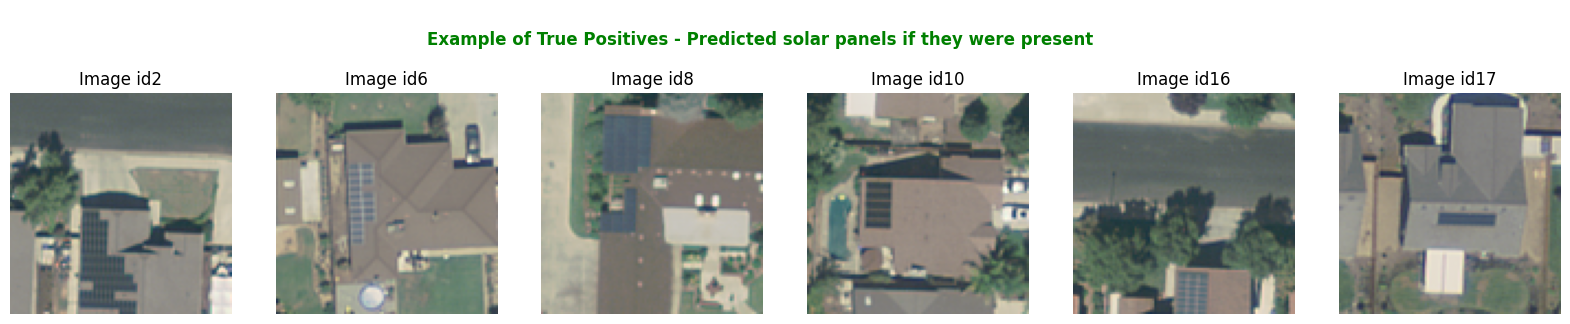

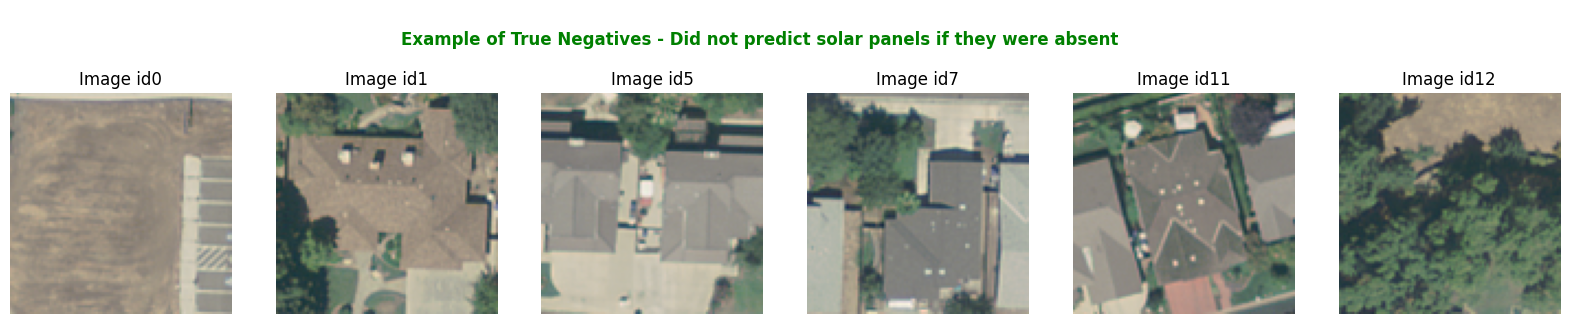

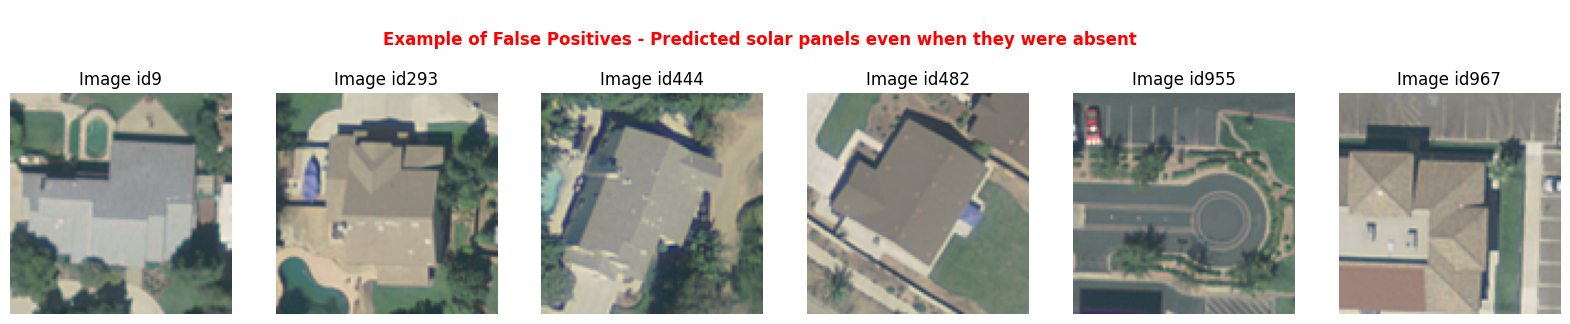

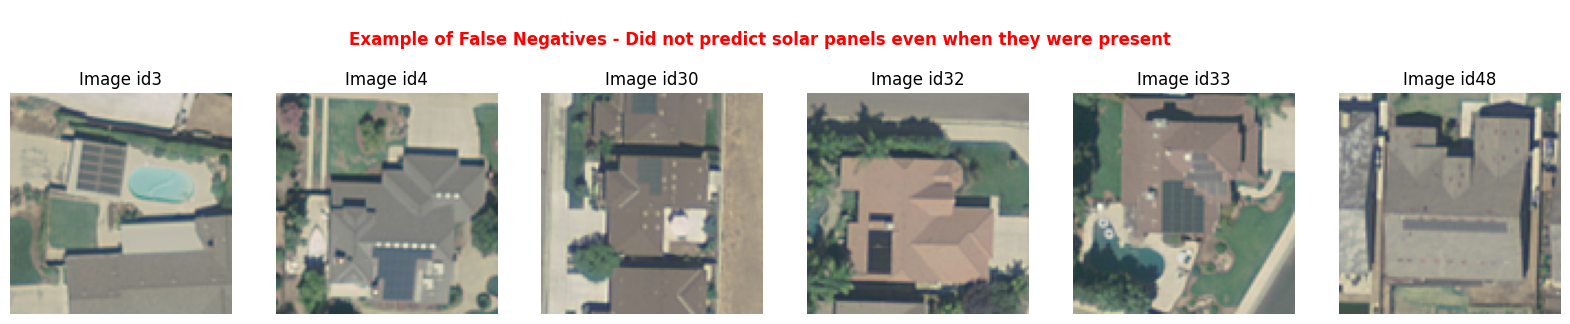

In [38]:
num_images = 6              #Number of images to look at

show_images(tp, num_images, "Example of True Positives - Predicted solar panels if they were present",'g')
show_images(tn, num_images, "Example of True Negatives - Did not predict solar panels if they were absent",'g')
show_images(fp, num_images, "Example of False Positives - Predicted solar panels even when they were absent",'r')
show_images(fn, num_images, "Example of False Negatives - Did not predict solar panels even when they were present",'r')

### ROC-AUC (Receiver Operating Characteristic Area under the Curve)
#### An ROC curve plots TPR vs. FPR at different classification thresholds.
- True Positive Rate
$$ TPR = \frac{TP}{TP+FN} $$
- False Positive Rate
$$ FPR = \frac{FP}{FP+TN}$$
Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives.

#### AUC(Area Under the ROC Curve)
- It measures the entire two dimensional area underneath the entire ROC Curve from 0 to 1. 
-  One way of interpreting AUC is as the **probability that the model ranks a random positive example more highly than a random negative example.**
- AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.
- **Higher the value of AUC, better is the classifier**


In [39]:
# ROC - AUC
def plot_roc(y_true, y_pred_cnn):
    '''
    Plots ROC curves for the CNN models.
    '''
    plt.figure(figsize=(8, 8))

    # ROC of CNN
    fpr, tpr, _ = roc_curve(y_true, y_pred_cnn, pos_label=1)
    auc = roc_auc_score(y_true, y_pred_cnn)
    legend_string = 'CNN Model - AUC = {:0.3f}'.format(auc)
    plt.plot(fpr, tpr, color='red', label=legend_string)

    # ROC of chance
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Chance - AUC = 0.5')

    # plot aesthetics
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.tight_layout()
    plt.title('ROC Curve', fontsize=10)
    pass

### The threshold is here 0.4 (instead of 0.5), Why?
- Keeping the threshold as 0.4 (not 0.5) as here false negative is significant and recall plays an important role here.
- False negative here means there were solar panels, but the model predicted no solar panels on the rooftop. To address this we have decreased the threshold value to 0.4, meaning if there is a probability>0.4, the model will detect solar panel.
- In the given scenario, the model incorrectly missed detecting instances of solar panels on rooftops, leading to a considerable number of false negatives (FN).
> To improve this, we lowered the detection threshold from the usual 0.5 to 0.4. This adjustment means that if the model predicts a probability higher than 0.4, it will identify it as a solar panel. By doing this, we aim to prioritize sensitivity (recall) over specificity, ensuring that fewer actual solar panels are overlooked by the model.

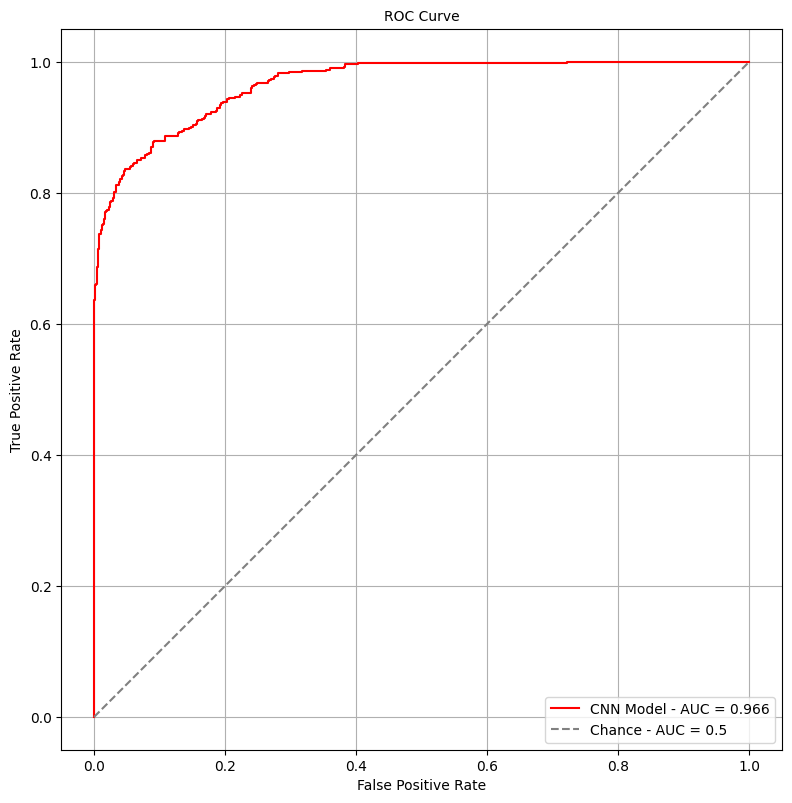

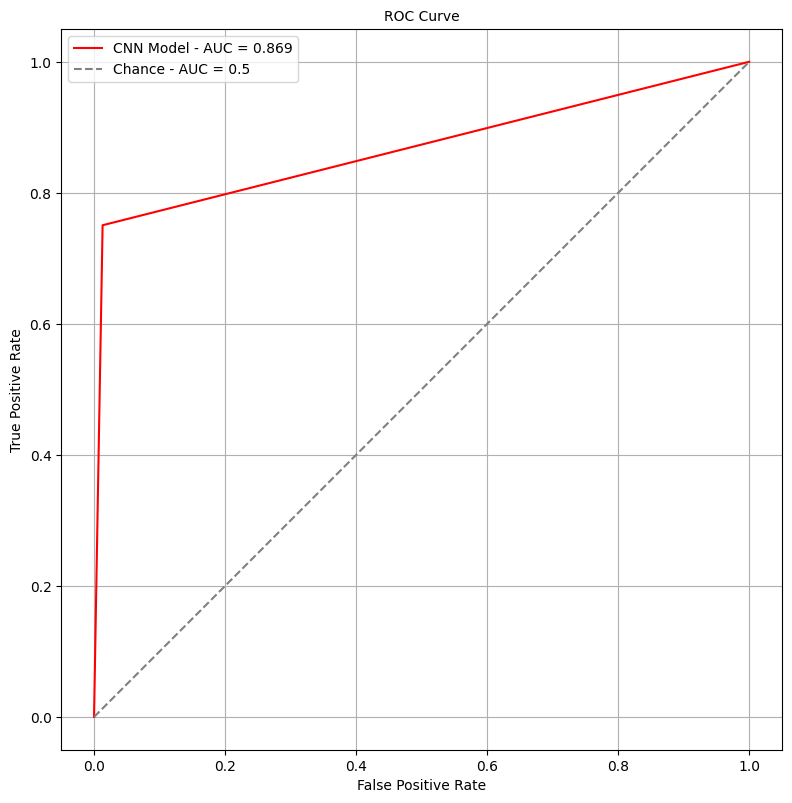

In [40]:
# plot ROC
y_pred = [1 if pred >= 0.4 else 0 for pred in y_pred_cnn]    # Keeping the threshold as 0.4 (not 0.5) as here false negative is significant and recall plays an important role here. 
plot_roc(y,  y_pred_cnn)
plot_roc(y, y_pred)

In [41]:
auc = roc_auc_score(y,y_pred,average='macro')
print(f"AUC Score of CNN Model with a threshold of 0.4: {auc}")

AUC Score of CNN Model with a threshold of 0.4: 0.8687148614358924


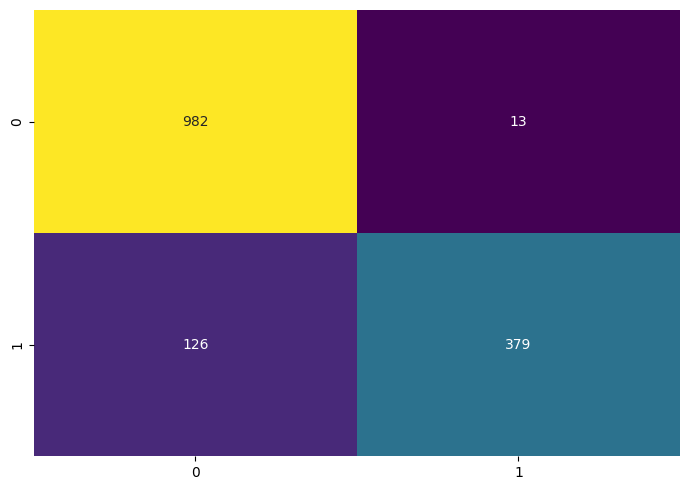

In [46]:
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y,y_pred),cmap='viridis' ,annot=True,cbar=False, fmt='.0f')
plt.tight_layout()
plt.show()

#### Observations:
- High TP and TN:
    - The model correctly predicted 982 instances as positive and 379 instances as negative.
- Low FP:
    - Only 13 instances were falsely predicted as positive (false alarms).
- Moderate FN:
    - 126 instances were predicted negative but were actually positive (missed detections).
    
#### Model Performance:
- The model demonstrates a strong ability to identify true positives (TP) and true negatives (TN) but has a few false negatives (FN).

In [43]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_pred, y))

              precision    recall  f1-score   support

           0       0.99      0.89      0.93      1108
           1       0.75      0.97      0.85       392

    accuracy                           0.91      1500
   macro avg       0.87      0.93      0.89      1500
weighted avg       0.93      0.91      0.91      1500

